In [ ]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("kundanbedmutha/exam-score-prediction-dataset")

print("Path to dataset files:", path)
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
df = pd.read_csv(os.path.join(path, csv_files[0]))

Using Colab cache for faster access to the 'exam-score-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/exam-score-prediction-dataset


# Dataset Datasheet

### 1. Motivation

This dataset was created to analyze multiple factors that contribute to student exam performance. The goal is to build a predictive model capable of flagging students at risk of failing before they take their final exam.

### 2. Target Definition

The problem is inherently a Binary Classification task. We will convert the continuous variable `Exam_Score` into a binary target variable called `At_Risk`.

* **1 (At Risk):** The student is at risk of failing (Exam Score < 60).
* **0 (Safe):** The student is safe (Exam Score  60).

**Cost Analysis:**

* **False Negative (High Cost):** The model predicts a student is "Safe" (0), but they actually fail. This is a high cost because the student receives no help in advance and subsequently fails the course.
* **False Positive (Low Cost):** The model predicts a student is "At Risk" (1), but they were actually fine. This is a low cost because the consequence is simply that the student receives extra tutoring they didn't strictly need. This outcome is not harmful.

### 3. Data Source & License/Terms

* **Source:** Kaggle
* **Type:** Synthetic Data (Artificially generated to mirror real-world logic).
* *Generation Method:* The author used a statistical rule-based approach rather than collecting real-world data. First, student profiles and behavioral factors (like study hours, sleep, and attendance) were assigned random values within realistic ranges. Finally, the target variable (`Exam_Score`) was calculated using a weighted mathematical formula that combined these factors—awarding points for positive behaviors like high attendance—plus a random "noise" variable to simulate natural variation.


* **License:** Attribution 4.0 International (CC BY 4.0).
* **Privacy:** Contains no Personally Identifiable Information as the records are simulated.

### 4. Brief Feature Dictionary

Below are the primary features used for prediction (after cleaning):

| Feature Name | Data Type | Description |
| --- | --- | --- |
| `Hours_Studied` | Numeric | Average number of hours spent studying per day. |
| `Attendance` | Numeric | Percentage of classes attended by the student. |
| `Sleep_Hours` | Numeric | Average daily sleep duration. |
| `Previous_Scores` | Numeric | Scores from previous tests (if available). |
| `Tutoring_Sessions` | Numeric | Number of extra tutoring sessions attended per month. |
| `Access_to_Resources` | Categorical | Availability of internet and study materials (High/Low). |

### 5. Known Limitations & Risks

* **Synthetic Nature:** As this data is artificially generated, it may be "too clean." It might lack the messy, irrational human behaviors or data entry errors found in real-world educational records. The correlations (e.g., "more study = higher grade") may be stronger and more linear than in reality.
* **Leakage Risk (Crucial):** The original dataset contains the `Exam_Score`. This variable is a **direct leakage vector**. If included in the training data (X), the model will have perfect accuracy because the Target (`At_Risk`) is derived directly from it.
* *Mitigation:* `Exam_Score` must be dropped from the feature set `X` and used **only** to generate the `y` target variable.


* **Bias:** The data assumes logical correlations (e.g., better sleep = better grades). It may not account for external anomalies like student illness, test anxiety, or unfair grading practices.

### 6. Leakage-risk Note
For our dataset, we think that there aren't any leakages. However if our dataset was structured differently, there could be a possible leakage. For example, if within our dataset, we have a pattern where all `student_id` that ends with a $1$ are all good students and aren't at risk of failing. Models might see this pattern and predict whether a student is at risk of failing or not based on this. This would be information that we have, "leaked".

In [ ]:
# Data Size
print(df.shape)

# Amount of null values
df.isna().sum()

(20000, 13)


,0
student_id,0
age,0
gender,0
course,0
study_hours,0
class_attendance,0
internet_access,0
sleep_hours,0
sleep_quality,0
study_method,0


In [ ]:
# general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


In [ ]:
# statistics of the dataset (numeric columns)
df.describe()

,student_id,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,10000.504600,20.473300,4.007604,70.017365,7.00856,62.513225
std,5773.654959,2.284458,2.308313,17.282262,1.73209,18.908491
min,1.000000,17.000000,0.080000,40.600000,4.10000,19.599000
25%,5000.750000,18.000000,2.000000,55.100000,5.50000,48.800000
50%,10000.500000,20.000000,4.040000,69.900000,7.00000,62.600000
75%,15000.250000,22.000000,6.000000,85.000000,8.50000,76.300000
max,20001.000000,24.000000,7.910000,99.400000,9.90000,100.000000


In [ ]:
# statistics of the dataset (categorical columns)
df.describe(include=['O'])

# count: amount of non-null row entries in a column
# unique: amount of unique categories
# top: most frequent category
# freq: amount of times the most frequent category appeared

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,20000,20000,20000,20000,20000,20000,20000
unique,3,7,2,3,5,3,3
top,other,bca,yes,average,self-study,medium,moderate
freq,6726,2902,16988,6694,4079,6760,9878


In [ ]:
# is the data imbalanced?
# df.exam_score.value_counts(normalize=True) #normalizes the result
results = pd.cut(df['exam_score'],
                 bins=[-float('inf'), 59, float('inf')],
                 labels=['Below 60', '60 and Above']).value_counts(normalize=True)

print(results)

exam_score
60 and Above    0.5705
Below 60        0.4295
Name: proportion, dtype: float64


''

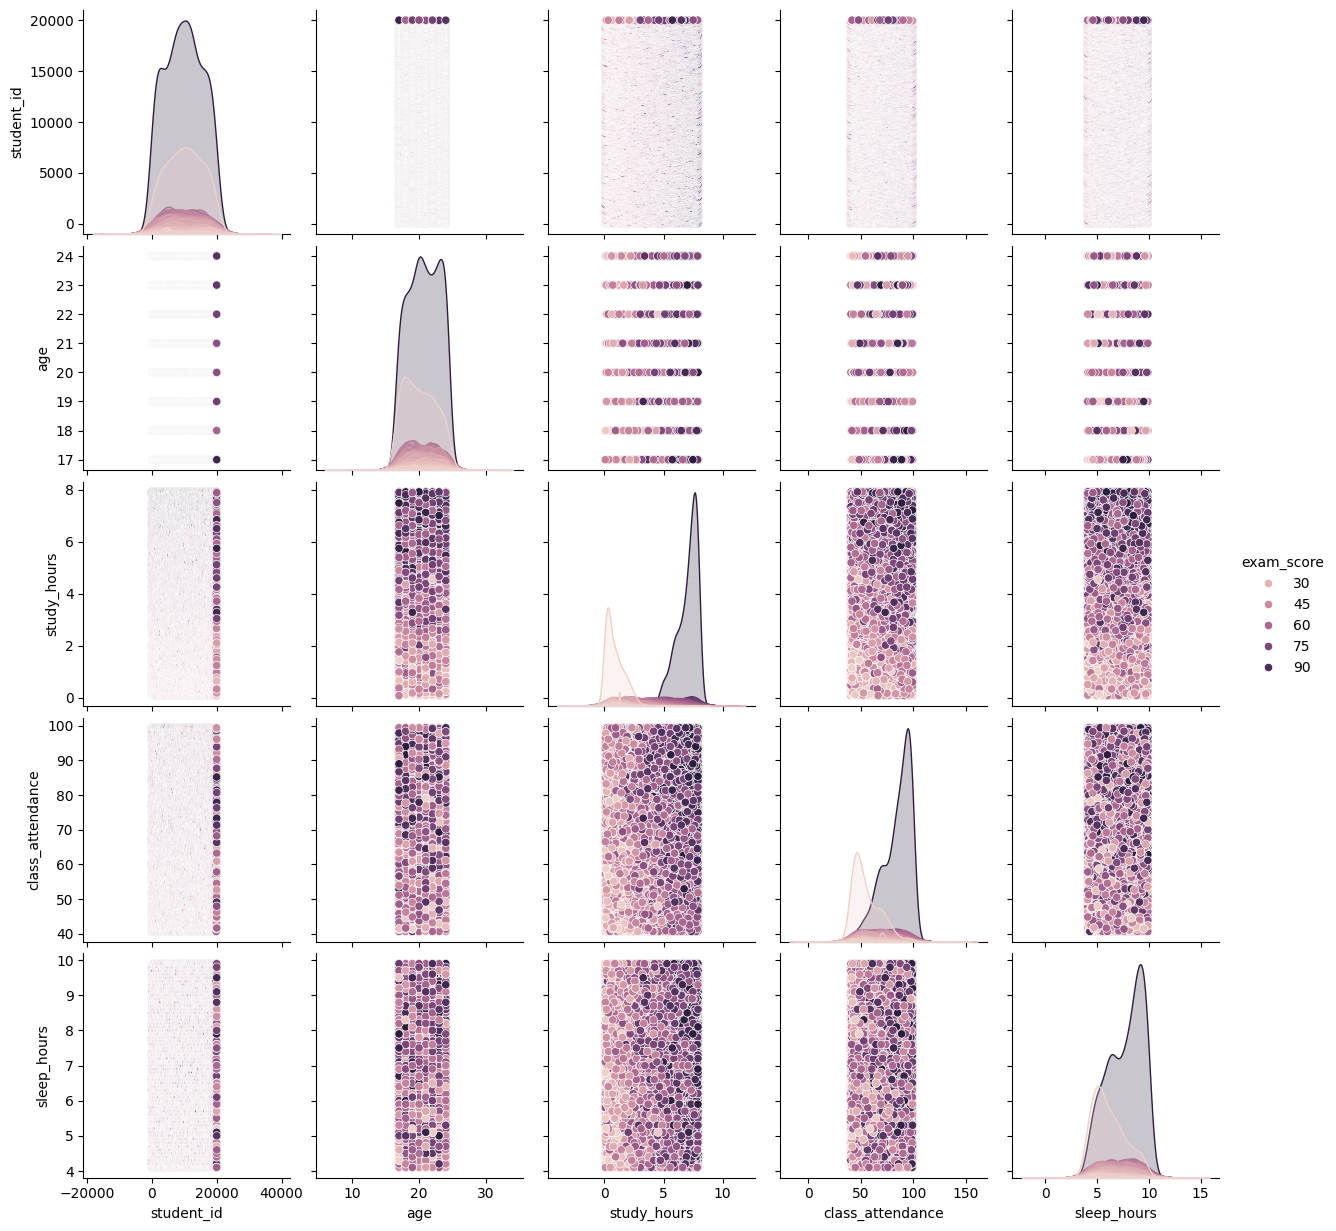

In [ ]:
# ploting pairwise relationships in the dataset
sns.pairplot(df, hue='exam_score')
,

''

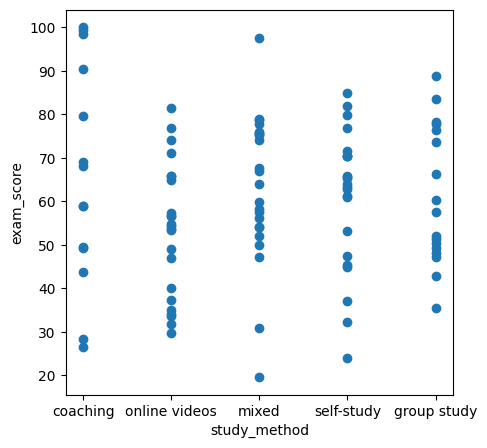

In [ ]:
# useful for identifying relationship (i.e. correlation) between two parameters
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(df[0:100].study_method, df[0:100].exam_score)
ax.set_xlabel('study_method')
ax.set_ylabel('exam_score')
,

''

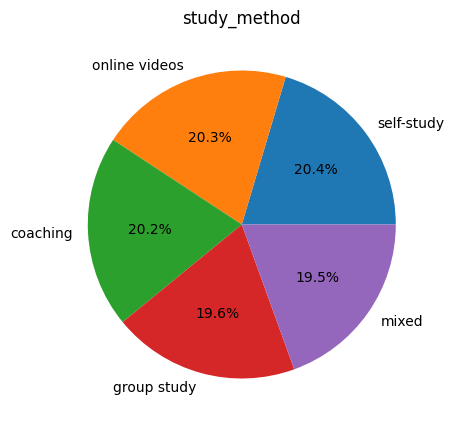

In [ ]:
# useful for depicting proportional data with each slice of pie representing a specific category
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(x=df.study_method.value_counts(),
       labels=df.study_method.value_counts().index,
       autopct='%1.1f%%')
ax.set_title('study_method')
,

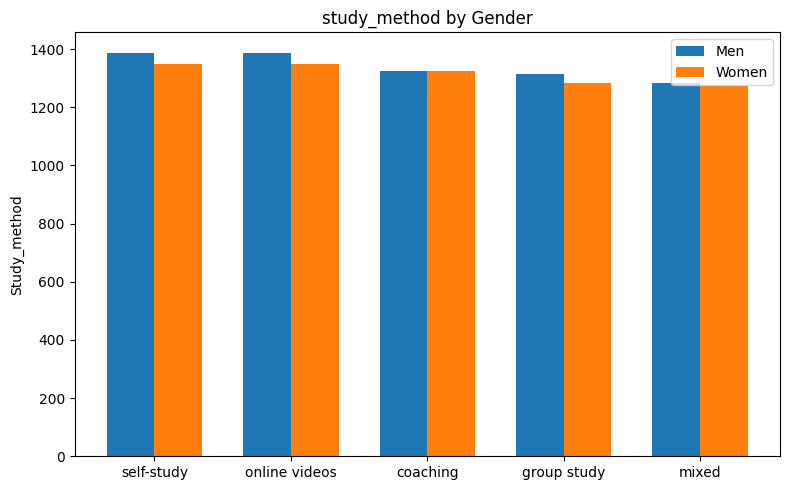

In [ ]:
# useful for comparing things between different groups or to track changes over time
labels = df.study_method.value_counts().index
men_study_method = df.loc[df.gender=='male'].study_method.value_counts()
women_study_method = df.loc[df.gender=='female'].study_method.value_counts()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, men_study_method, width, label='Men')
rects2 = ax.bar(x + width/2, women_study_method, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Study_method')
ax.set_title('study_method by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

''

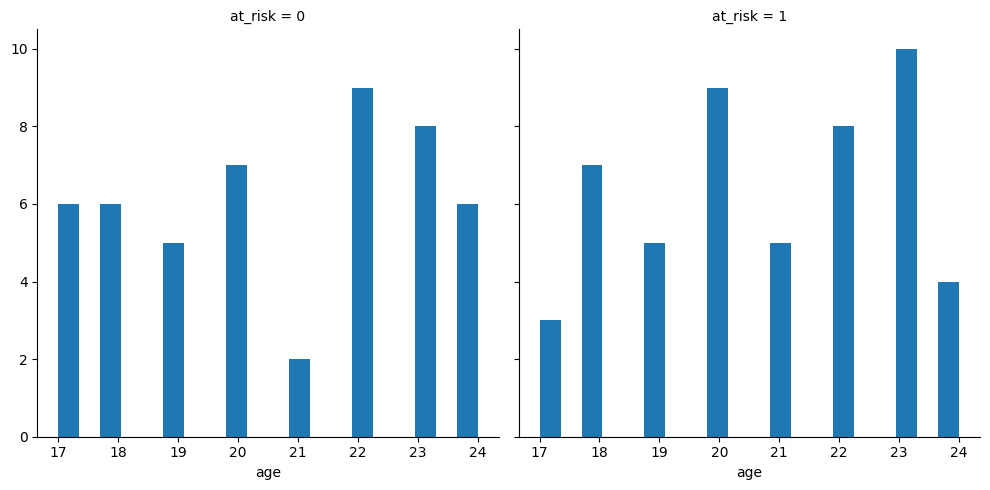

In [ ]:
# Add a classification column
df['at_risk'] = pd.cut(df['exam_score'],
                      bins=[-float('inf'), 59, float('inf')],
                      labels=[1, 0]).astype(int)

# useful for visualizing the distribution of the data
g = sns.FacetGrid(df[0:100], col='at_risk', height=5)
g.map(plt.hist, 'age', bins=20)

# Feature Engineering and Encoding

In [ ]:
# perform label encoding for internet_access column
df.internet_access = df.internet_access.map({ 'no': 0, 'yes': 1})

In [ ]:
# one hot encoding of Embarked and Title columns
for column in ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']:
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = pd.concat([df, dummies], axis=1).drop([column], axis=1)


# ADDED Dropfirst = True
# Purpose: Reduce multicolinearity on categories implying one another.

''

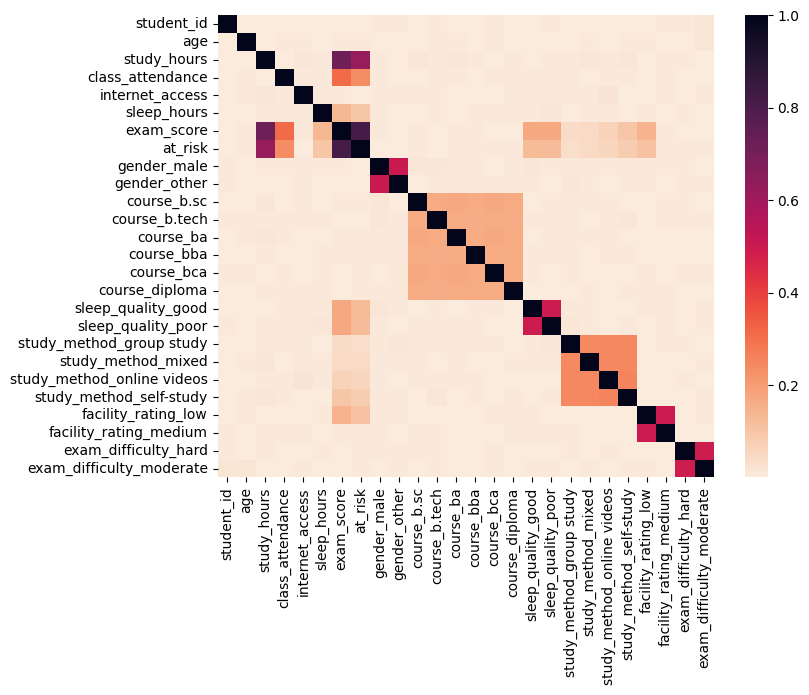

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df.corr().abs(),annot=False, ax=ax, cmap='rocket_r')
,

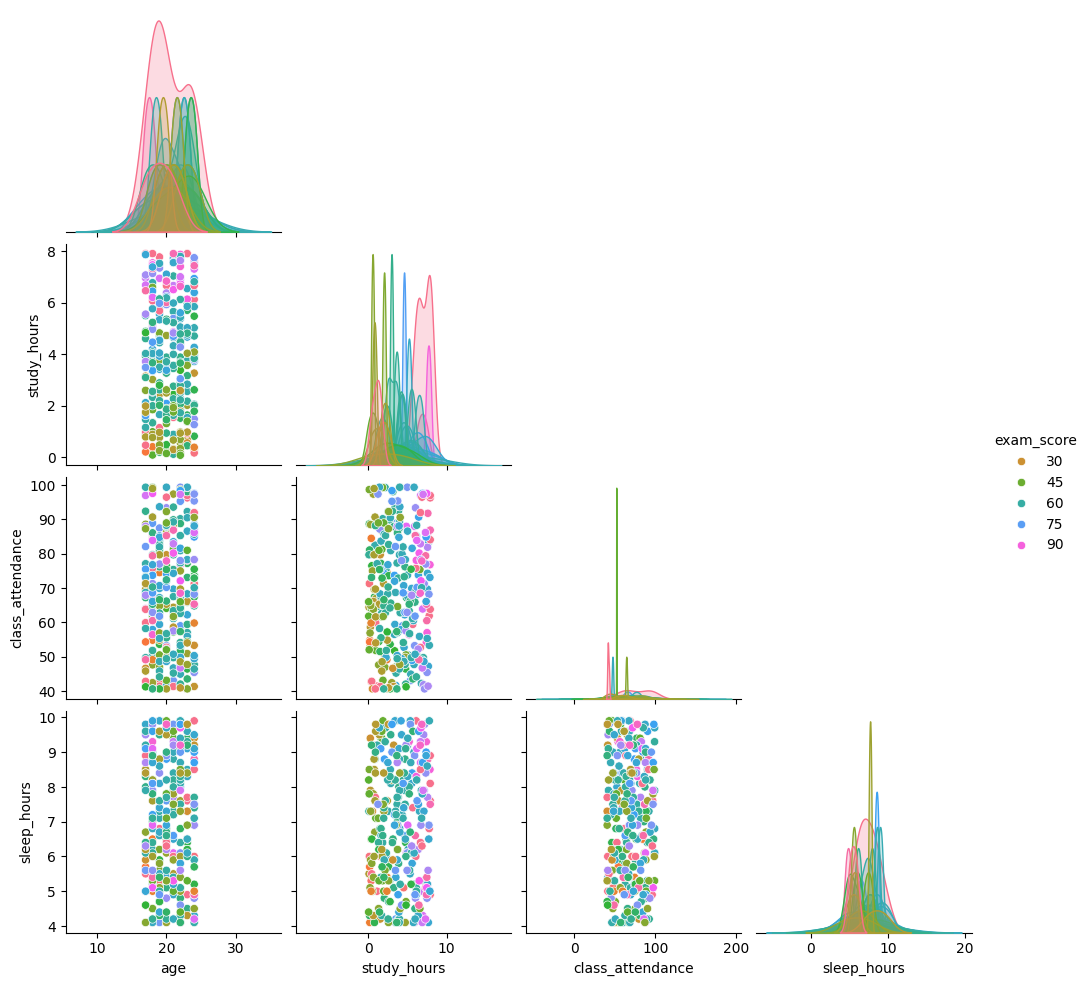

In [ ]:
# 1. Select the features you want to visualize
features = ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']

# 2. Create the pairplot
# diag_kind='kde' creates the smooth density curves on the diagonal
# corner=True removes the redundant upper triangle of the matrix
sns.pairplot(df[features].sample(300),
             hue='exam_score',
             diag_kind='kde',
             palette='husl',
             corner=True)

plt.show()

In [ ]:
# feature correlation with target variable
df.corr(numeric_only=True)['exam_score'].sort_values(ascending=False)

,exam_score
exam_score,1.000000
at_risk,0.817599
study_hours,0.717788
class_attendance,0.308850
sleep_quality_good,0.172049
sleep_hours,0.133222
study_method_mixed,0.044980
facility_rating_medium,0.010613
course_bba,0.008920
age,0.006522


# Partitioning The Data

In [ ]:
# Split the data
X = df.drop(columns=['student_id', 'exam_score', 'at_risk'])
y = df['at_risk']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.asarray(X_train, dtype=np.float64)
y_train = np.asarray(y_train, dtype=np.float64)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16000, 23) (4000, 23)
(16000,) (4000,)


# Feature Scaling

In [ ]:
scaler = StandardScaler()
# Fit only on training data to avoid leaking info from the test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# Predict